# Project 2

Mael Illien, Jeremy O'Brien, Vanita Thompson

### Assignment:

1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

3. What can you infer about each of the distinct groups?


### Setup

In [131]:
# Import modules
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import io
import requests
from scipy import stats
from pylab import rcParams
import math
%matplotlib inline

### The Dataset: Kaggle IMBD

We will utilize a [Kaggle dataset of movie data](https://www.kaggle.com/PromptCloudHQ/imdb-data/downloads/imdb-data-from-2006-to-2016.zip/1) that uses IMDB as its source. It's limited to the 1000 most popular movies made from 2006-2016 at the time of the author's data pull. 

In [132]:
#read csv into pandas as a dataframe
url="https://raw.githubusercontent.com/Vthomps000/DATA620/master/Movies.csv"
s=requests.get(url).content
imdb=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [133]:
imdb.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


### Data transformation

We transform the data by spliting the Actors column into individual actors and storing the (Movie:Actor) pairs in a data frame.

In [186]:
#separate and pivot csv actor list
#(https://stackoverflow.com/questions/50789834/parse-a-dataframe-column-by-comma-and-pivot-python)
from  itertools import product
mov_actlist = imdb[['Title','Actors']] # Only keep columns on interest
mov_act = mov_actlist.applymap(lambda x: x.split(',') if isinstance (x, str) else [x])
mov_act = pd.DataFrame([j for i in mov_act.values for j in product(*i)], columns=['Movie','Actor'])
mov_act.head(10)

,Movie,Actor
0,Guardians of the Galaxy,Chris Pratt
1,Guardians of the Galaxy,Vin Diesel
2,Guardians of the Galaxy,Bradley Cooper
3,Guardians of the Galaxy,Zoe Saldana
4,Prometheus,Noomi Rapace
5,Prometheus,Logan Marshall-Green
6,Prometheus,Michael Fassbender
7,Prometheus,Charlize Theron
8,Split,James McAvoy
9,Split,Anya Taylor-Joy


In [172]:
#imdb2['Title'].str.strip() 

In [171]:
#imdb2['Title'] = (imdb2['Title']).str.strip()
#imdb2['Actors'] = (imdb2['Actors']).str.strip()
#imdb2.describe

We can now create a graph from the data frame.

In [173]:
#G=nx.from_pandas_edgelist(imdb2,'Title','Actors',edge_attr=True)
G=nx.from_pandas_edgelist(mov_act,'Movie','Actor')

Calling info will give us a total number of nodes (number of movies plus number of actors) and edges (total number of movie apperances in the dataset of 1000 movies). We also get average degree, which, in this 2-mode dataset, is a not particularly meaningful mix of average actors listed in the movies in the dataset and average number of the 1000 popular movies in which an actor is listed.

In [174]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3401
Number of edges: 4035
Average degree:   2.3728


The number of edges matches the number of rows from our dataframe, which matches our expectations. Now, let's do some analysis to prepare for visualization. First, is our graph connected?

In [175]:
nx.is_connected(G)

False

In [176]:
nx.number_connected_components(G)

140

In [177]:
nx.is_bipartite(G)

True

MI: I would remove this these few lines

It is not connected. I will look at an individual node's connectivity. I'll use the movie Guardians of the Galaxy.

In [179]:
#G.degree('Guardians of the Galaxy') # MI: I would remove these lines

In [180]:
#G.edges('Guardians of the Galaxy') # MI: I would remove these lines

In [181]:
#G.edges('Zoe Saldana') # MI: I would remove these lines

Based on the idea of the 1000 most popular movies from 2006-2016, it seems that our dataset would be connected. Every movie would have a major cast member in at least one other movie, one would think. Maybe there are some foreign films or documentaries that made the list without any crossover from major cast members.

In order to perform more analysis, we need to isolate the connected component. We'll take the largest using subsetting. 

### Connected components and subgraphs

We see from the list below that there are a number of subgraphs in this network, including one very large one of size 2633.

In [196]:
sorted([len(c) for c in nx.connected_components(G) if len(c) > 5], reverse=True)

[2633, 17, 13, 13, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 6, 6]

In [202]:
#Create connected subgraphs
#G_connected_list = list(nx.connected_component_subgraphs(G))
#G_connected_list = [G.subgraph(c) for c in nx.connected_components(G)] # networkx 2.4
subgraphs = [(G.subgraph(c),len(c)) for c in nx.connected_components(G) if len(c) > 5] # networkx 2.4
subgraphs = sorted(subgraphs, key = lambda x: x[1], reverse=True)

subgraphs[:5]

[(<networkx.classes.graph.Graph at 0x12df12750>, 2633),
 (<networkx.classes.graph.Graph at 0x12df12090>, 17),
 (<networkx.classes.graph.Graph at 0x12df12b50>, 13),
 (<networkx.classes.graph.Graph at 0x12d5fc090>, 13),
 (<networkx.classes.graph.Graph at 0x12df12850>, 9)]

In [205]:
#Isolate the largest subgraph
#G_connected = G_connected_list[0]
#print(nx.info(G_connected))
largest_subg = subgraphs[0][0]
print(nx.info(largest_subg))

Name: 
Type: Graph
Number of nodes: 2633
Number of edges: 3395
Average degree:   2.5788


In [206]:
#Isolate the second largest subgraph
#G_connected_2 = G_connected_list[1]
#print(nx.info(G_connected_2))
print(nx.info(subgraphs[1][0]))

Name: 
Type: Graph
Number of nodes: 17
Number of edges: 16
Average degree:   1.8824


In [207]:
#Isolate the third largest subgraph
G_connected_3 = G_connected_list[2]
print(nx.info(subgraphs[2][0]))

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 12
Average degree:   1.8462


The movies/actors involved.

In [210]:
#G_connected_2.edges() # MI: I would remove these

In [211]:
#G_connected_3.edges() # MI: I would remove these

We will just go with the largest subgraph, which we'll rename G.

In [215]:
#Verify bipartite
G=largest_subg
print('Is this graph bipartite: {} \nIs this graph connected: {}'.format(nx.is_bipartite(G),nx.is_connected(G)))

Is this graph bipartite: True 
Is this graph connected: True


### Visualization

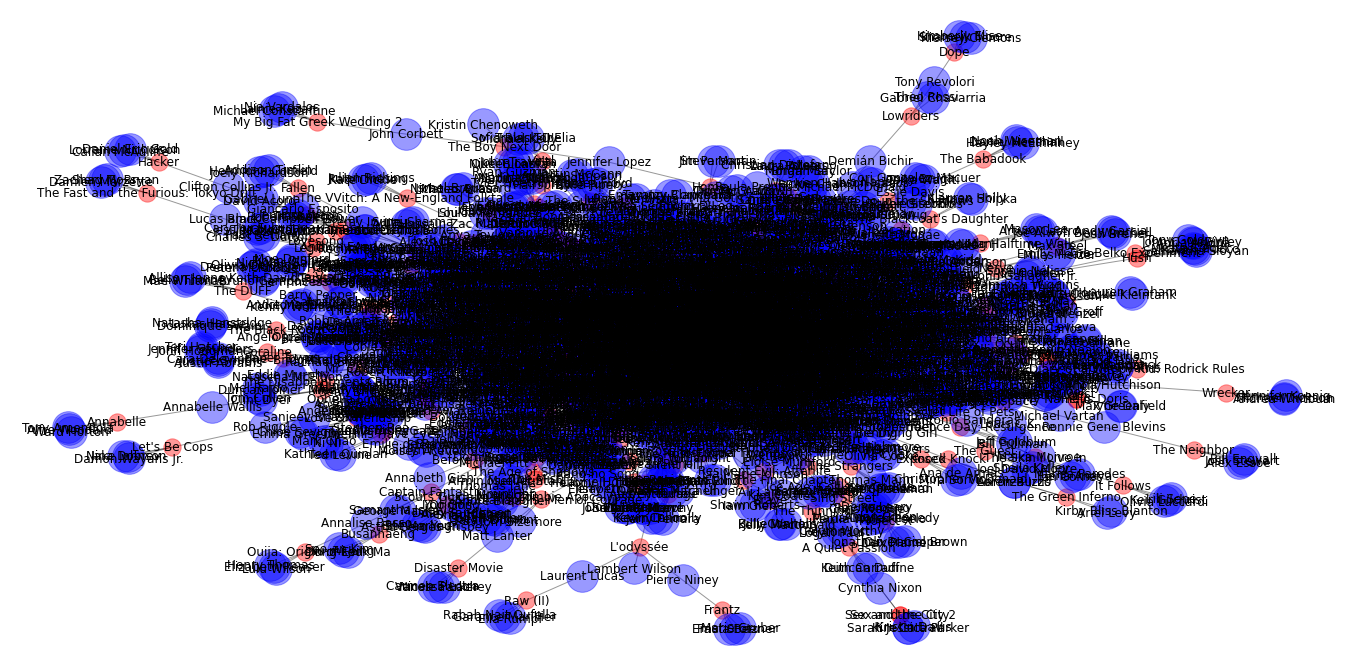

In [24]:
import warnings
warnings.filterwarnings("ignore")

# Visualize the 2-mode networks
Titles, Actors = nx.bipartite.sets(G)
plt.rcParams["figure.figsize"] = (24,12)
plt.axis('off')
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=Titles, node_color='red', alpha = 0.4)
nx.draw_networkx_nodes(G, pos, nodelist=Actors, node_color='blue', alpha = 0.4, node_size = 1000)
nx.draw_networkx_edges(G, pos, alpha = 0.4)
nx.draw_networkx_labels(G, pos);

In [25]:
print('radius =', nx.radius(G))

radius = 11


Any nodes with eccentricities near the radius of a graph are likely in the center. We would guess that these would be either movies with large diverse (in terms of genre breadth) casts or actors who choose a wide variety or role types.

In [26]:
print('center =', nx.center(G))

center = ['Guardians of the Galaxy', 'Prometheus', 'Interstellar', 'Mad Max: Fury Road', 'Inglourious Basterds', 'The Wolf of Wall Street', 'Gone Girl', 'Avengers: Age of Ultron', 'The Departed', 'The Dark Knight Rises', 'Mamma Mia!', 'Into the Woods', 'No Country for Old Men', 'Shutter Island', 'Free Fire', 'Dawn of the Planet of the Apes', 'Spotlight', 'Iron Man', 'Old Boy', "The Huntsman: Winter's War", 'Jackie', 'Fury', 'Les Misérables', 'Zodiac', 'The Devil Wears Prada', 'In Time', 'Hail', 'Caesar!', 'Criminal', 'Wanted', 'Collide', 'Steve Jobs', 'Couples Retreat', 'Atonement', 'Filth', 'The Other Guys', 'American Gangster', 'The Book of Eli', 'Men in Black 3', 'Savages', 'Chappie', 'Elysium', 'A Good Year', 'Jack Reacher', 'Limitless', 'Fantastic Four', 'Snow White and the Huntsman', 'The Finest Hours', 'Moneyball', 'Sunshine', "Daddy's Home", 'Megamind', 'Anna Karenina', 'Pain & Gain', 'Child 44', 'Tinker Tailor Soldier Spy', 'Genius', 'The Hollars', 'Closed Circuit', 'Nymphoman

In [27]:
print('diameter =', nx.diameter(G))

diameter = 18


### Centrality

I will look at centrality metrics using the process in Chapter 3 of our textbook.

In [28]:
def sortSecond(val):
    return val[1]

In [29]:
#create function to retrieve sorted degree list
#ch 3 p. 47 of textbook
#plus internet searches to adapt for ch 3
from operator import itemgetter as ig

def sorted_map(map):
    ms = sorted(map.items(), key=ig(1), reverse=True)
    return ms

In [30]:
d=dict(G.degree())
ds=sorted_map(d)
ds[:10]

[('Mark Wahlberg', 15),
 ('Hugh Jackman', 14),
 ('Christian Bale', 13),
 ('Brad Pitt', 13),
 ('Michael Fassbender', 12),
 ('Scarlett Johansson', 12),
 ('Ryan Gosling', 12),
 ('Emma Stone', 12),
 ('Anne Hathaway', 12),
 ('Robert Downey Jr.', 12)]

Degrees here simply captures the number of times a node appears in the dataset. So Wahlberg's in the most of the top 1000 movies from 2006-2016. Between bad action movies and some surprise hit comedies, this makes sense. Movies would show up here only if they had larger casts included in the dataset.

In [31]:
c=nx.closeness_centrality(G)
cs=sorted_map(c)
cs[:10]

[('Christian Bale', 0.17806247300993233),
 ('Mark Wahlberg', 0.172404181184669),
 ('Brad Pitt', 0.17156726768377253),
 ('Charlize Theron', 0.16942884536364883),
 ('Hugh Jackman', 0.16919710025988238),
 ('Matt Damon', 0.16864349011588275),
 ('Leonardo DiCaprio', 0.16850565318076557),
 ('Anna Kendrick', 0.16827642497619372),
 ('The Dark Knight Rises', 0.16803640562385383),
 ('Michael Fassbender', 0.16786538200569956)]

Closeness centrality measures a node's ability to communicate with others. In our book's example, these are the gossip mongers. 

From a movie industry perspective, this would be a node's ability to reach all other nodes in the network with fewest edges. Notice that, whereas our distance measure of centers highlighted mostly movies, here we get almost all actors.

In [32]:
b=nx.betweenness_centrality(G)
bs=sorted_map(b)
bs[:10]

[('Mark Wahlberg', 0.04219311673395823),
 ('Christian Bale', 0.038022735167341615),
 ('Channing Tatum', 0.03391862711228865),
 ('Hugh Jackman', 0.03183830856383147),
 ('Charlize Theron', 0.028704173024282062),
 ('Brad Pitt', 0.027683278966693002),
 ('Tom Hardy', 0.025643091428860478),
 ('Matthew McConaughey', 0.025445461670917557),
 ('Sharlto Copley', 0.02462683278891274),
 ('Anne Hathaway', 0.02438752430474505)]

Betweenness centrality, according to our textbook, is based on the idea that power resides in bottlenecks between networks. So a cross-genre actor like Hugh Jackman who appears in action films, musicals, and romantic comedies might be an important connector to different groups of actors.

Summing our centrality measures up:

In [61]:
#from pg. 54

names1=[x[0] for x in ds[:10]]
names2=[x[0] for x in cs[:10]]
names3=[x[0] for x in bs[:10]]

names=list(set(names1) | set(names2) | set(names3))
table=[[name,d[name],c[name],b[name]] for name in names]
print(pd.DataFrame(table, columns=['actor','degree','closeness','betweeness']))

                    actor  degree  closeness  betweeness
0               Brad Pitt      13   0.171567    0.027683
1              Emma Stone      12   0.156167    0.017697
2         Charlize Theron      10   0.169429    0.028704
3              Matt Damon      10   0.168643    0.017123
4      Scarlett Johansson      12   0.165374    0.018906
5       Robert Downey Jr.      12   0.158793    0.013046
6      Michael Fassbender      12   0.167865    0.022847
7            Ryan Gosling      12   0.160026    0.017143
8       Leonardo DiCaprio      10   0.168506    0.019885
9          Channing Tatum      12   0.160462    0.033919
10    Matthew McConaughey      10   0.166375    0.025445
11         Sharlto Copley       9   0.166869    0.024627
12         Christian Bale      13   0.178062    0.038023
13          Anna Kendrick      11   0.168276    0.021553
14          Anne Hathaway      12   0.167820    0.024388
15              Tom Hardy      12   0.165021    0.025643
16          Mark Wahlberg      

The odd-man out here is probably Sharlto Copley, but a quick glance at his IMDB page reveals why his weird resume makes him a connector between a wide variety of actors.

Now let's look at eigenvector measurements, a metric that captures degree centrality. This looks to detect what the book calls "gray cardinals" by weighting connections to well-connected nodes more than the less ones.

In [34]:
e=nx.eigenvector_centrality_numpy(G)
es=sorted_map(e)
es[:10]

[('Steve Carell', 0.30967516483386043),
 ('Ryan Gosling', 0.26621757911556115),
 ('Emma Stone', 0.24162543342309606),
 ('Crazy', 0.1902775922309534),
 ('Stupid', 0.1902775922309534),
 ('Love.', 0.1902775922309534),
 ('The Big Short', 0.16589684249180078),
 ('Christian Bale', 0.15333277115081287),
 ('Julianne Moore', 0.14821035290109408),
 ('Jennifer Garner', 0.14073946971474216)]

Here we see a possible issue with our data import - the commas in the title of the movie Crazy, Stupid, Love led to duplicate records for that movie and likely cause the cast to have overrated measures here. 

Let's separate the modes.

### Unipartite projection

In [35]:
#create network only containing actors
G_act = bipartite.projected_graph(G, Actors)
nx.is_connected(G_act)

True

In [36]:
print(nx.info(G_act))

Name: 
Type: Graph
Number of nodes: 1575
Number of edges: 5151
Average degree:   6.5410


In [37]:
list(G_act.edges())[:10]

[('Jessica Barth', 'Seth MacFarlane'),
 ('Jessica Barth', 'Amanda Seyfried'),
 ('Jessica Barth', 'Mark Wahlberg'),
 ('Henry Thomas', 'Annalise Basso'),
 ('Henry Thomas', 'Elizabeth Reaser'),
 ('Henry Thomas', 'Lulu Wilson'),
 ('Will Dalton', 'Ruth Negga'),
 ('Will Dalton', 'Dean Mumford'),
 ('Will Dalton', 'Joel Edgerton'),
 ('Tina Fey', 'Will Ferrell')]

We see what we'd expect - the edges now are between actors in the same movie rather than actors and movies in which they star.

We will now look at groupings, first using the built-in find_cliques function and then using a modified version of the island method described in the book.

In [38]:
list(nx.find_cliques(G_act))[:30]

[['Léa Seydoux', 'Nathalie Baye', 'Marion Cotillard', 'Vincent Cassel'],
 ['Léa Seydoux', 'Daniel Craig', 'Ralph Fiennes', 'Christoph Waltz'],
 ['Léa Seydoux',
  'Adèle Exarchopoulos',
  'Salim Kechiouche',
  'Aurélien Recoing'],
 ['Henry Thomas', 'Annalise Basso', 'Elizabeth Reaser', 'Lulu Wilson'],
 ['Octavia Spencer', 'Kevin Costner', 'Taraji P. Henson', 'Janelle Monáe'],
 ['Octavia Spencer', 'Emma Stone', 'Bryce Dallas Howard', 'Viola Davis'],
 ['Clive Owen', 'Chiwetel Ejiofor', 'Julianne Moore', 'Michael Caine'],
 ['Clive Owen', 'Chiwetel Ejiofor', 'Denzel Washington'],
 ['Clive Owen', 'Jason Clarke', 'Liana Liberato', 'Catherine Keener'],
 ['Clive Owen', 'Jodie Foster', 'Denzel Washington', 'Christopher Plummer'],
 ['Kiernan Shipka', 'Emma Roberts', 'Lucy Boynton', 'Lauren Holly'],
 ['John Cullum', 'Chris Evans', 'Emma Fitzpatrick', 'Alice Eve'],
 ['Haley Joel Osment', 'Genesis Rodriguez', 'Justin Long', 'Michael Parks'],
 ['Will Dalton', 'Ruth Negga', 'Dean Mumford', 'Joel Edger

Much of these cliques are just the casts listed for a film. Let's use our version of the island method to find some true islands. Beyond a single degree, will we just see the casts of franchise films, or might we see director-specific cliques?

As a reminder, our starting dataset for analysis is itself as subgraph, so we've already "raised the water" slightly.

In [56]:
#pg. 64 book revised to trim nodes based on degree centrality
    
def trim_nodes(g, degree=1):
    g2=g.copy() #copy graph so that original is not altered adn to avoid error below
    for (node, val) in g.degree(): #must be run on original graph or dictionary will change size during iteration
            if val < degree:
                g2.remove_node(node)
    return g2

In [102]:
#pg. 64 book revised to trim nodes based on degree centrality, return df with additional into

def degree_island_method(g, iterations=5):

    degree = [val for (node, val) in g.degree()]
    
    mn=int(min(degree))
    mx=int(max(degree))
    step=int((mx-mn)/(iterations))
    # A list of threshold and trimmed graph pairs
    island_list = [[deg_threshold, trim_nodes(g, deg_threshold)] for deg_threshold in range(mn,mx,step)]
    
    for item in island_list:
        g_trim = item[1]
        num_nodes = len(g_trim.nodes)
        item.append(num_nodes)
        #num_subgraphs = len(list(nx.connected_component_subgraphs(item[1])))
        
        num_subgraphs = len([g_trim.subgraph(c) for c in nx.connected_components(g_trim)]) # networkx 2.4
        item.append(num_subgraphs)
    
    df = pd.DataFrame(island_list, columns = ['Degree Threshold', 'Graph','Number of Nodes', 'Number of Subgraphs'])
    return df


In [109]:
df = degree_island_method(G_act, 8)
print(df.drop(['Graph'], axis=1))

   Degree Threshold  Number of Nodes  Number of Subgraphs
0                 2             1575                    1
1                 7              420                    1
2                12              250                    1
3                17              130                    2
4                22               61                    2
5                27               33                    2
6                32               12                    3
7                37                4                    1


Because degree has a different real-life meaning for each node type in the bipartite graph (how many movies an actor has starred in versus how many cast members a movie has), we have tested a modified version of the "island method" on the projected, actors-only graph. 

The '''degree_island_method''' function removes nodes in an iterative, step-wise fashion, increasing the threshold for minimum degree necessary to remain in the graph each time. It differs from the version given in the text because our graph does not have edge weights. 

Interestingly, most of the levels have only one subgraph, suggesting that there is one, main clique.

We can now write a brief function to draw all of the graphs with some custom formatting and labels. We will map node size to degree for easier reading. Note: While in the bipartite graph, and actor's degree indicated the number of movies they starred in, the the '''G_act''' projected graph, it indicates the number of other actors with whom they've shared a credit in the database. So, more movies ***and*** more diverse casting or casting in larger ensembles will all increase the degree.

In [127]:
import warnings
def draw_islands(df, i):
    warnings.filterwarnings("ignore")
    
    G = df['Graph'][i]
    H = df['Graph'][0]
    #node_size = [float(H.degree(v))*100 for v in H] #sizes nodes according to connectedness in first iteration
    node_size = [G.degree(v)*100 for v in G] #sizes nodes according to connectedness in first iteration
    plt.rcParams.update({'font.size': 22})

    plt.rcParams["figure.figsize"] = (24,24)
    plt.axis('off')
    
    title = str("Island Method Iteration # %d\nThreshold for Inclusion: %s Shared Movie Credits in Database" % (i, df['Degree Threshold'][i]))
    plt.title(title)
    
    pos=nx.spring_layout(G)
    nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, alpha=0.8)
    nx.draw_networkx_labels(G, pos=pos, font_size=18, alpha = 0.9)

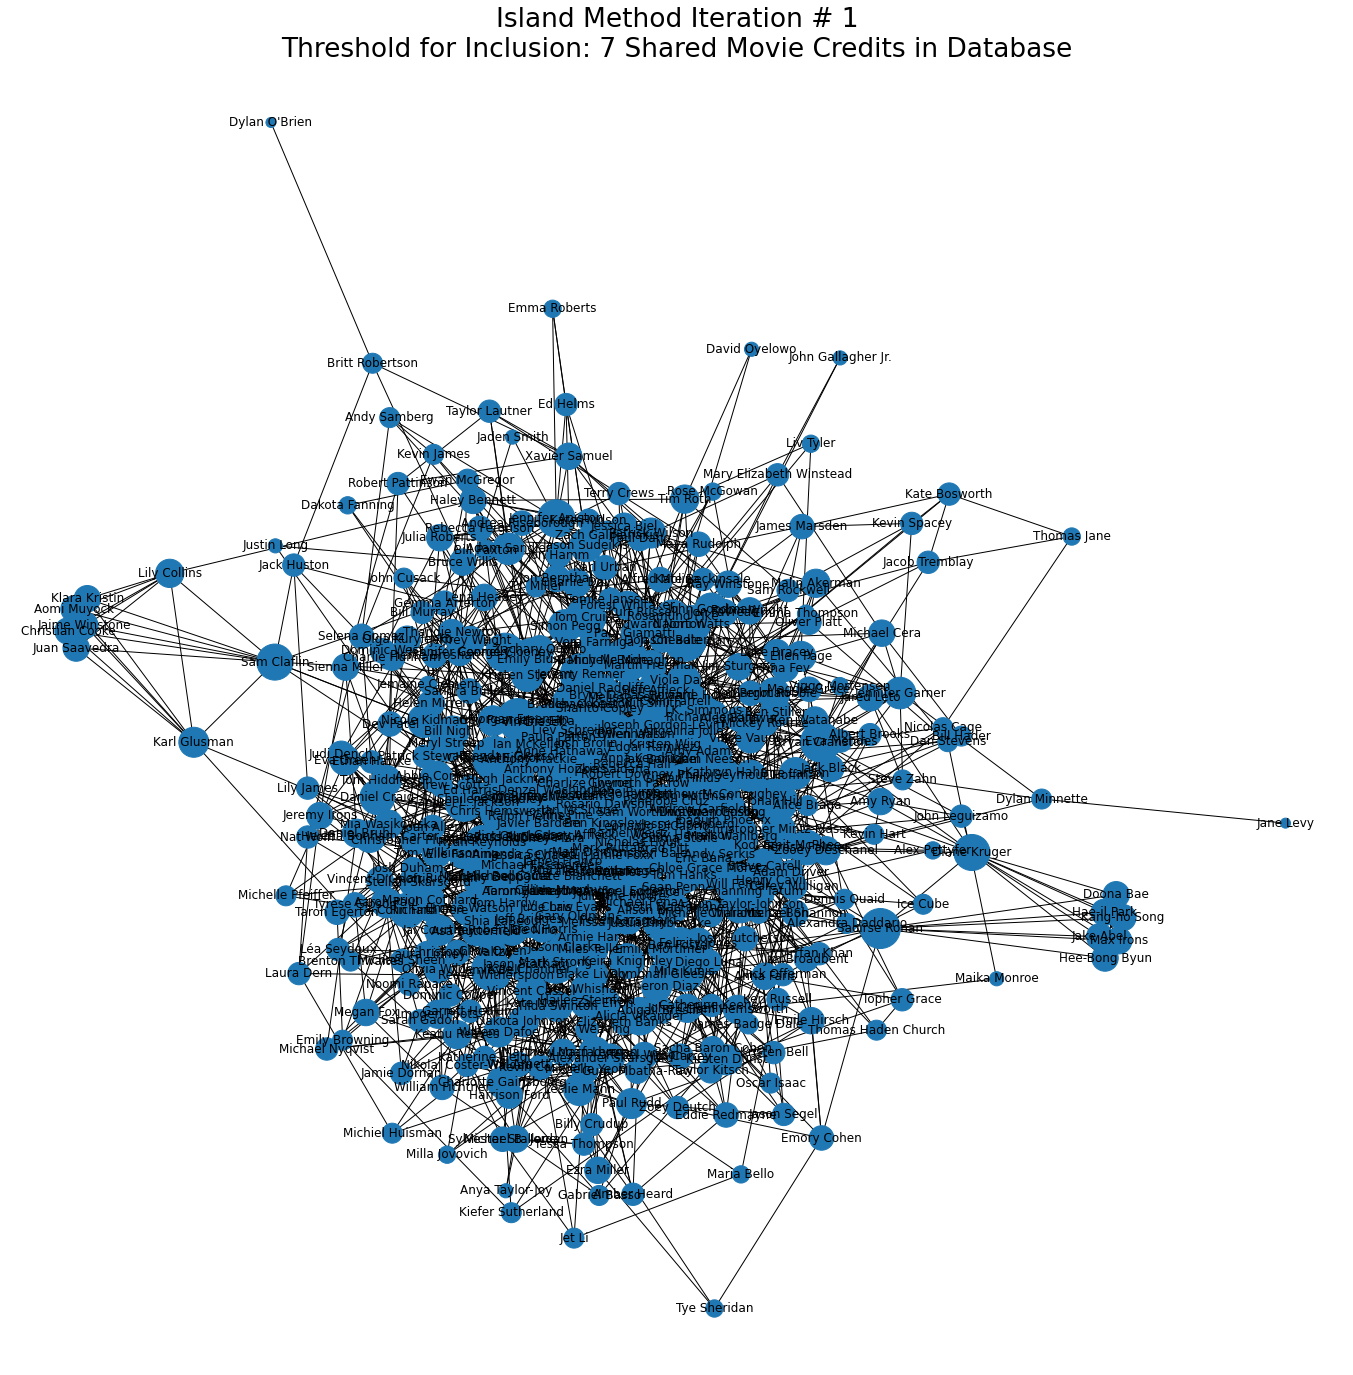

In [128]:
draw_islands(df, 1)

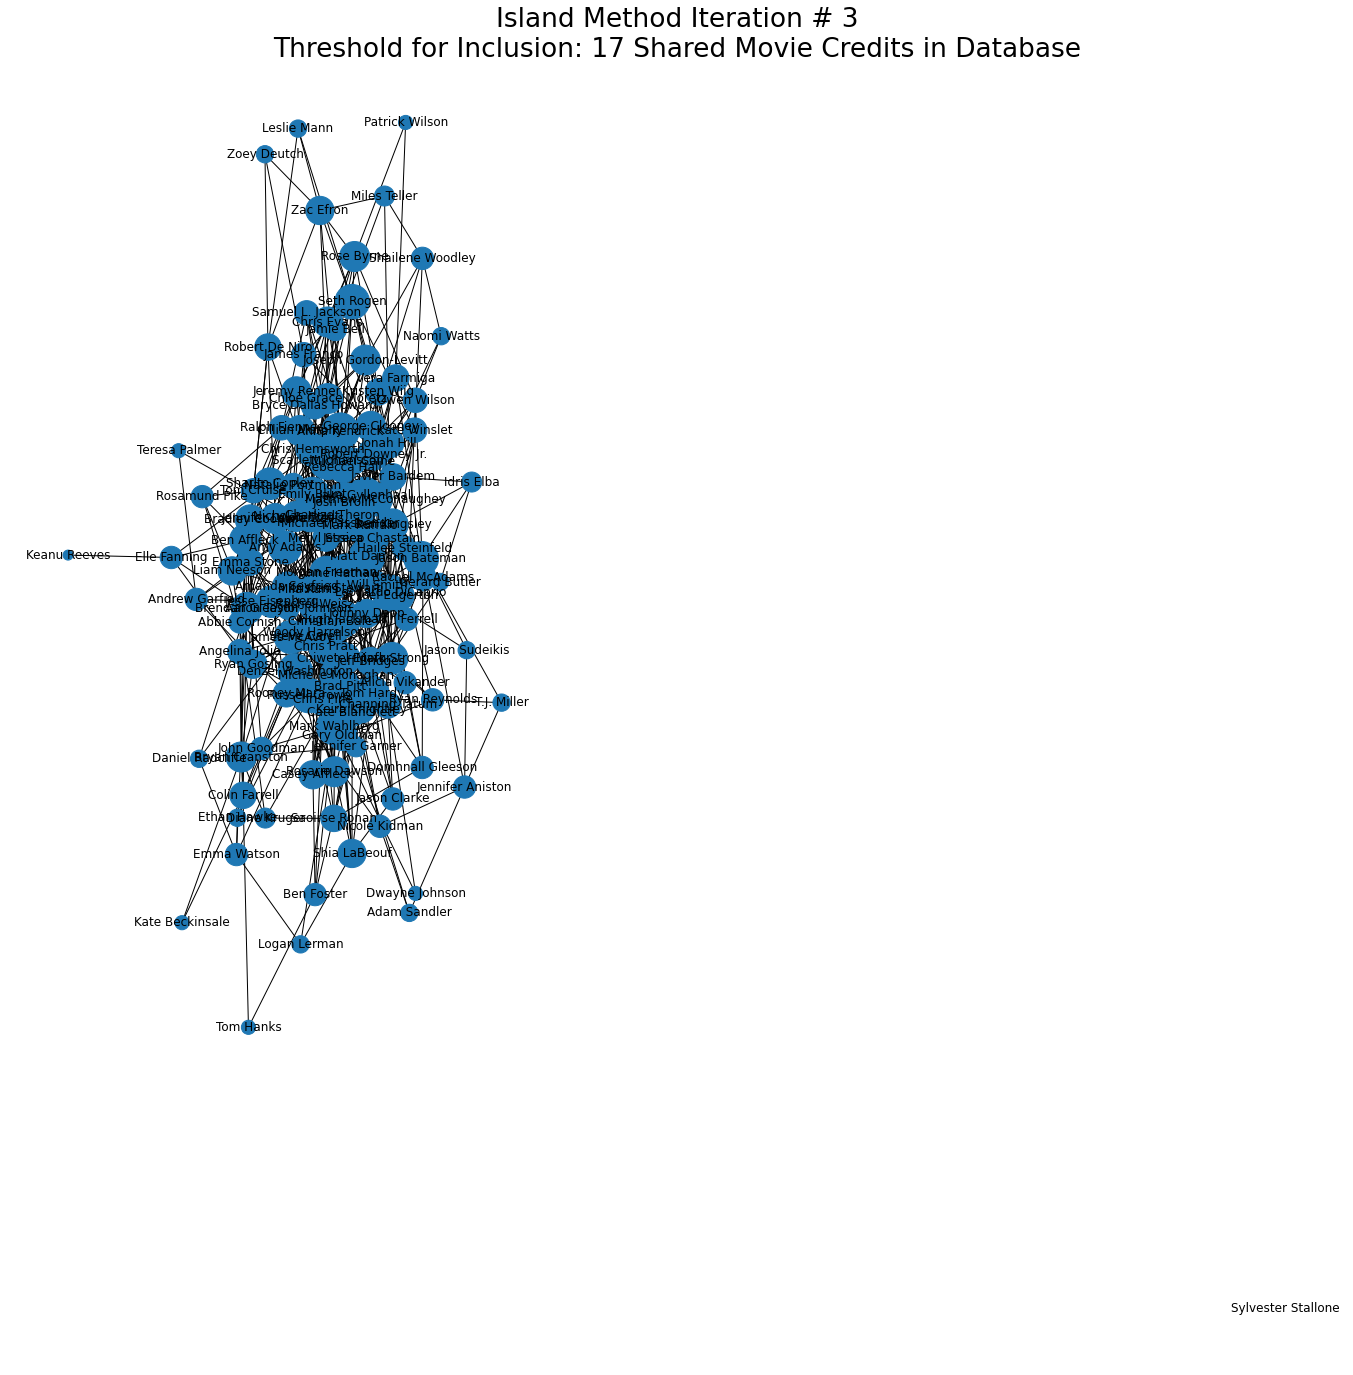

In [129]:
draw_islands(df, 3)

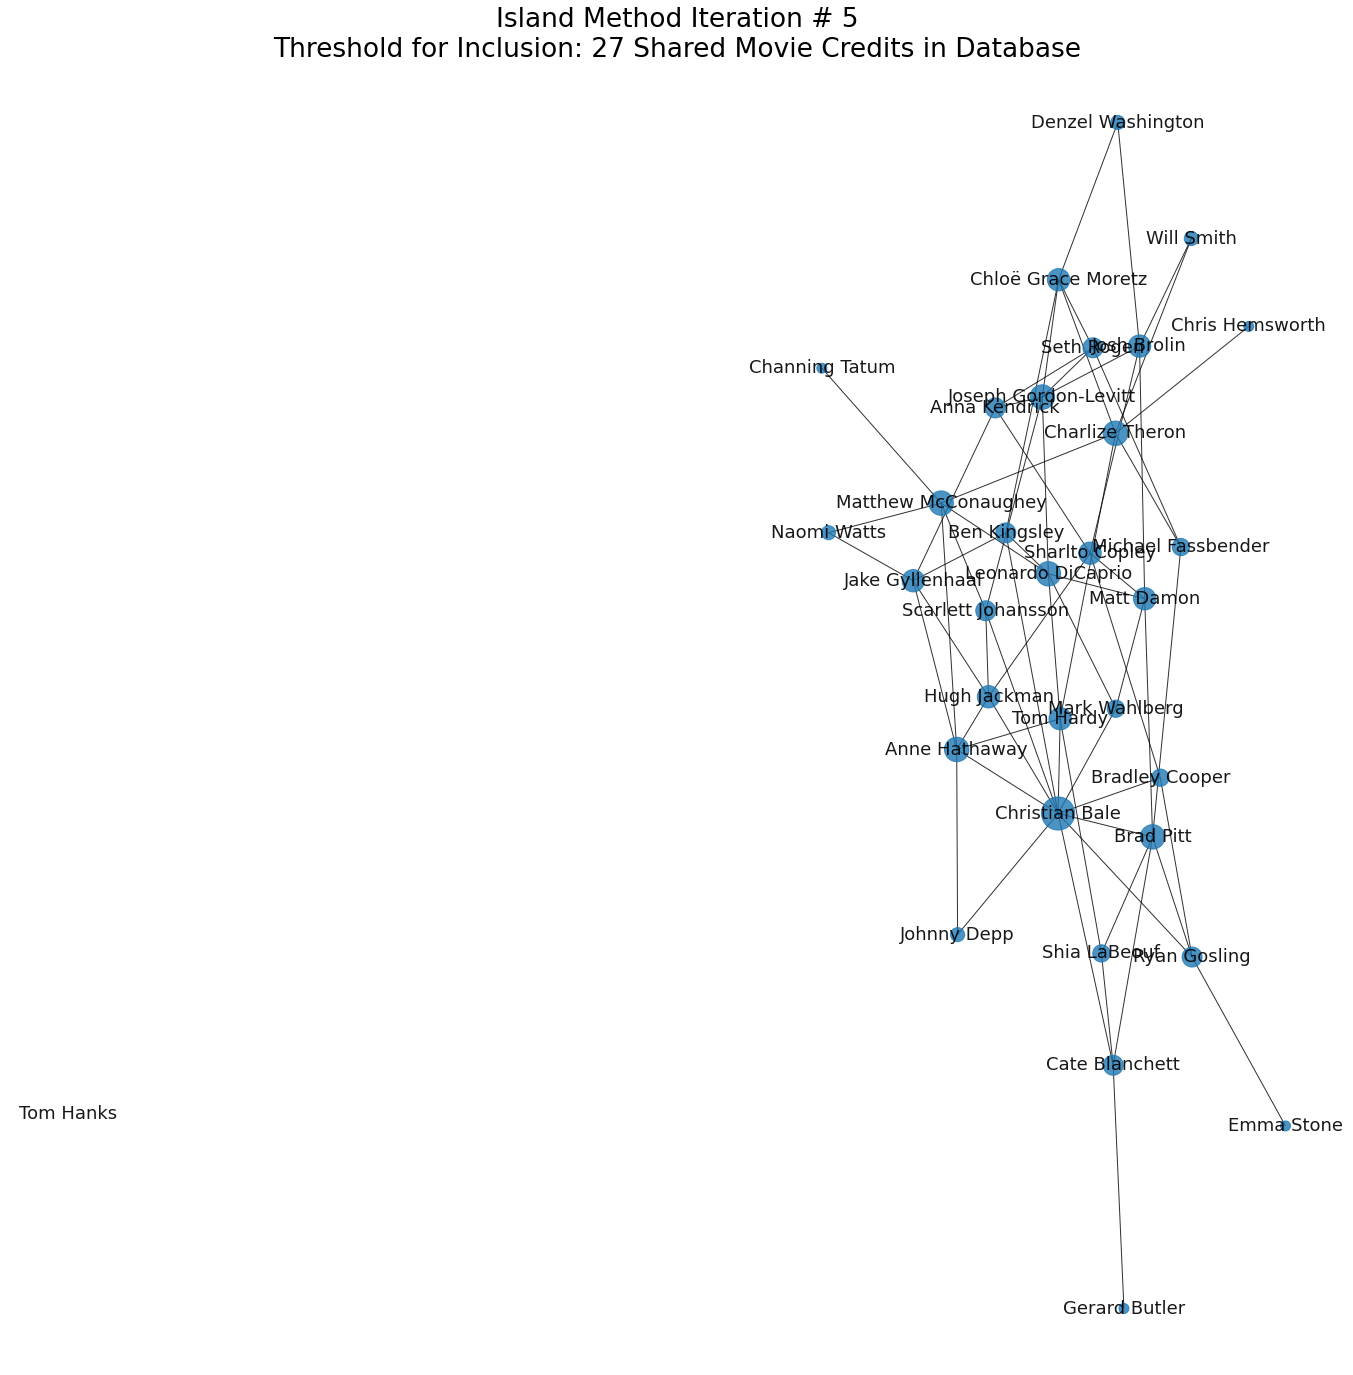

In [123]:
draw_islands(df, 5)

In the graph above, for actors who have been in at least 27 movies, we see a densely connected graph of well-known actors and--all by himself--Tom Hanks. 

What this means is that Tom Hanks has at least 2 degrees of separation from anyone in the central subgraph. Someone get that guy in a movie with Denzel!

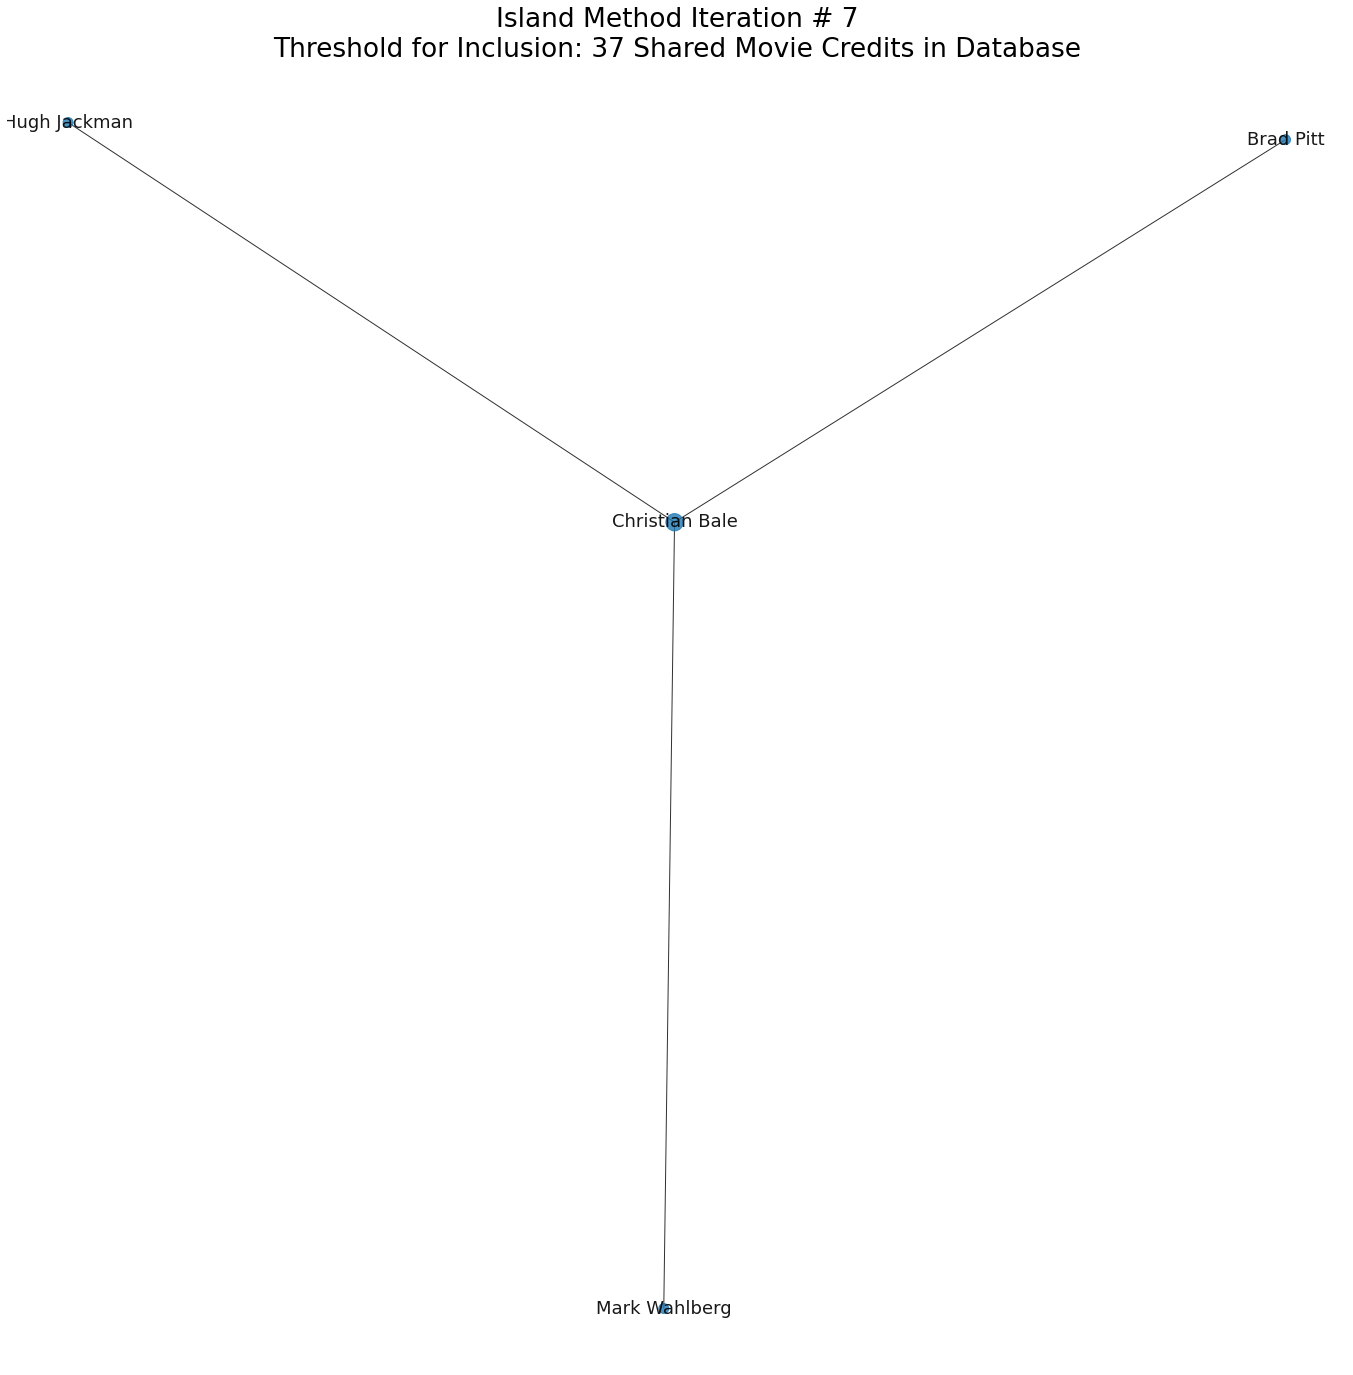

In [124]:
draw_islands(df, 7)

### Conclusion
